In [1]:
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# rank wine into good or bad
# function receiving a target and returning a binary value depending if target >= predefined threshold
def make_binary(target, threshold):
    if target >= tf.constant(threshold, dtype=tf.int32):
        return 1
    else:
        return 0

In [3]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer= regularizers.l2(0.001))
        self.hidden_layer2 = tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer= regularizers.l2(0.001))
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.output_layer = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

    @tf.function
    def call(self, inputs, training = False):
        x = self.hidden_layer1(inputs)
        x = self.hidden_layer2(x)
        if training:
            x = self.dropout(x, training=training)    
        x = self.output_layer(x)
        return x

In [4]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        sample_train_accuracy =  target == np.round(prediction)
        sample_train_accuracy = np.mean(sample_train_accuracy)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, sample_train_accuracy

def validate(model, val_data, loss_function):
    # test over complete test data

    val_accuracy_aggregator = []
    val_loss_aggregator = []

    for (input, target) in val_data:
        prediction = model(input)
        sample_val_loss = loss_function(target, prediction)
        sample_val_accuracy =  target == np.round(prediction)
        sample_val_accuracy = np.mean(sample_val_accuracy)
        val_loss_aggregator.append(sample_val_loss.numpy())
        val_accuracy_aggregator.append(np.mean(sample_val_accuracy))

    val_loss = tf.reduce_mean(val_loss_aggregator)
    val_accuracy = tf.reduce_mean(val_accuracy_aggregator)

    return val_loss, val_accuracy


def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  target == np.round(prediction)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy


In [5]:
# Visualize accuracy and loss for training and test data.
def plotting(train_losses, test_losses, val_losses, train_accuracies, test_accuracies, val_accuracies):
    # plot losses
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    line3, = plt.plot(val_losses)
    plt.title("Loss")
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2,line3),("Loss train","Loss test","Loss validate"))
    plt.show()
    
    # plot accuracies
    plt.figure()
    line1, = plt.plot(train_accuracies)
    line2, = plt.plot(test_accuracies)
    line3, = plt.plot(val_accuracies)
    plt.title("Accuracy")
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.legend((line1,line2,line3),("Accuracy train", "Accuracy test","Accuracy validate"))
    plt.show()
    

In [6]:
def prepare_dataset(dataset, threshold):
    # ranking wine in good and bad depending on threshold -> binary calssification
    # Data Pipeline 
    
    # map make_binary() function to dataset
    dataset = dataset.map(lambda inputs, target: (inputs, make_binary(target, threshold)))
  
    # shuffle
    dataset = dataset.shuffle(1599)
    
    # apply batching 
    dataset = dataset.batch(256)

    # prefetch data
    dataset = dataset.prefetch(256)

    #return preprocessed dataset
    return dataset  

## Preparation of data

In [7]:
# load data into a data frame
df_wine = pd.read_csv('winequality-red.csv', sep = ";", index_col = False)
# shuffle dataframe
df_wine = df_wine.sample(frac=1).reset_index(drop=True)

# define features and target labels
features = list(df_wine.columns)[:-1]
target = "quality"

# calculate threshold of all qualities using median
#threshold = df_wine[target].median()
threshold = 7

# Create a Tensorflow Dataset and a Dataset Pipeline
## split data frame into train(60%), test(20%), validation(20%)
train_df, test_df, val_df = np.split(df_wine.sample(frac=1, random_state=42), [int(0.6*len(df_wine)), int(0.8*len(df_wine))])

## convert dataframes into tensorflow datasets
train_ds = (
    tf.data.Dataset.from_tensor_slices(
        (tf.cast(train_df[features].values, tf.float32), tf.cast(train_df[target].values, tf.int32))
    )
)

test_ds = (
    tf.data.Dataset.from_tensor_slices(
        (tf.cast(test_df[features].values, tf.float32), tf.cast(test_df[target].values, tf.int32))
    )
)

val_ds = ( tf.data.Dataset.from_tensor_slices(
        (tf.cast(val_df[features].values, tf.float32), tf.cast(val_df[target].values, tf.int32))
    )
)

# prepare datasets
train_dataset = prepare_dataset(train_ds, threshold)

test_dataset = prepare_dataset(test_ds, threshold)
val_dataset = prepare_dataset(val_ds, threshold)      

## Training and plotting

SGD optimizer


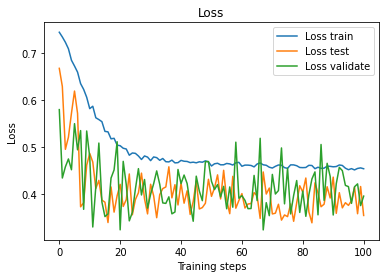

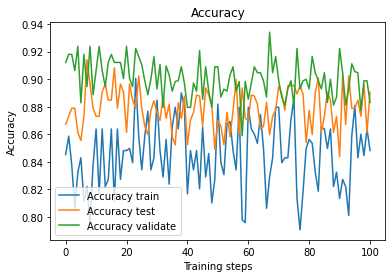

Adam optimizer


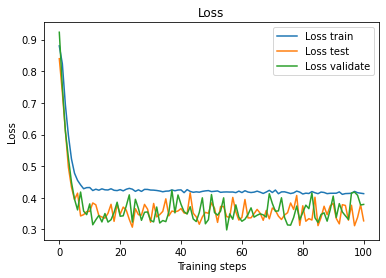

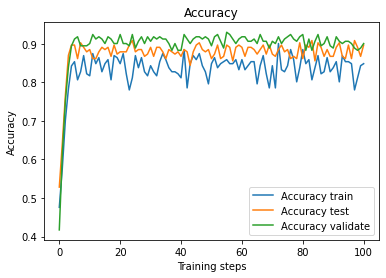

RMSprop optimizer


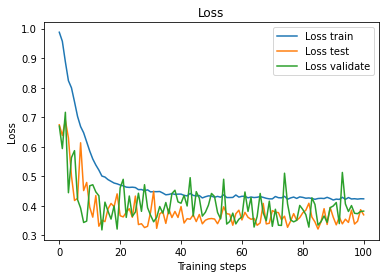

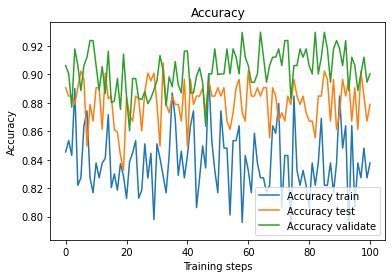

In [8]:
### Hyperparameters
num_epochs = 100
learning_rate = 0.0001
    
# Initialize the optimizers: SGD, Adam, RMSprop
optimizers = [tf.keras.optimizers.SGD(learning_rate), tf.keras.optimizers.Adam(learning_rate), tf.keras.optimizers.RMSprop(learning_rate)]
opt_labels = ["SGD", "Adam", "RMSprop"]
label = 0

for opt in optimizers:

    tf.keras.backend.clear_session()

    # Initialize the model.
    model = MyModel()
    # Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
    b_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()


    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []
    val_losses = []
    
    train_accuracies = []
    test_accuracies = []
    val_accuracies = []
    
    
    #testing once before we begin
    test_loss, test_accuracy = test(model, test_dataset, b_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #check how model performs on train data once before we begin
    train_loss, train_accuracy = test(model, train_dataset, b_cross_entropy_loss)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    #check how model performs on validate data once before we begin
    val_loss, val_accuracy = test(model, val_dataset, b_cross_entropy_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    
    # We train for num_epochs epochs
    for epoch in range(num_epochs):

        #training (and checking in with training)
        epoch_loss_agg = []
        epoch_acc_agg = []
        for input,target in train_dataset:
            train_loss, train_accuracy = train_step(model, input, target, b_cross_entropy_loss, opt)
            epoch_loss_agg.append(train_loss)

            #track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))
        # tracking train accuracy
        train_accuracies.append(tf.reduce_mean(train_accuracy))
        
        #testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, b_cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # validation
        val_loss, val_accuracy = validate(model, val_dataset, b_cross_entropy_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        #print(f' test_losses: {test_losses[-1]} , test_accuracies: {test_accuracies[-1]}')
        #print(f' val_losses: {val_losses[-1]}, test_accuracies: {test_accuracies[-1]}')
        
    print(opt_labels[label], "optimizer")
    label+=1

    plotting(train_losses, test_losses, val_losses, train_accuracies, test_accuracies, val_accuracies)